**```
this script introduces a preprocessing pipeline for pupilometry data collected with an eyelink-1000. this is accomplished through a class that loads raw ascii files (which were converted from .EDF), removes blinks using a straightforward polynomial interpollation (which can also be set to a linear interpolation), and bandpass filters the blink-corrected pupil diameter. if you're already familiar with python you can skim through the script to get a sense of how these steps are accomplished, or just skip to the bottom where the class is defined. because the data this is running on are in '../../collection/gaze_data/' relative to this folder, you can experiment with the preprocessing parameters untill you find something that seems "reasonable for your own purposes```**

> if you're not familiar with python this is a tutorial-esque description of how you might approach preprocessing eyelink gaze data in python. i've assumed you might not know anything about the language, so i move through some elementary steps in the beginning, along with the logic behind those steps and some helpful python conventions. wherever it wasn't too tedious--or i thought it might have been especially benificial, even if it was--i describe the thinking that lead to the design decisions. so it starts super slow, but picks up towards the end.```***


**```fist, let's import a module to load data from 'gaze_data/'```**

In [204]:
import os 

> let's set the path, populate a list with contents from our data folder, and data that matches some criteria. in this case 'd1.asc' are those day 1 files that have been converted to asc format. 

In [205]:
data_path = '../../collection/gaze_data/'
folder_contents = os.listdir(data_path)

data_file_names = []
for file in folder_contents: 
    if 'd1.asc' in file: 
        data_file_names.append(file)

In [206]:
print(data_file_names)

['s00_d1.asc', 's01_d1.asc', 's02_d1.asc', 's03_d1.asc', 's04_d1.asc', 's05_d1.asc', 's06_d1.asc', 's07_d1.asc', 's08_d1.asc', 's08x_d1.asc', 's09_d1.asc', 's09x_d1.asc', 's10_d1.asc', 's11_d1.asc', 's12_d1.asc', 's98_d1.asc', 's99_d1.asc']


> now let's set up to grab one subject of interest. s12 just to be consistent with what we've been looking at previously. 

In [207]:
subject_path = data_path + data_file_names[11]
print("relative path to a single subject's data: '%s'"%subject_path) 

relative path to a single subject's data: '../../collection/gaze_data/s09x_d1.asc'


> now lets load the actual data--and we're going to need to load another module to do that

In [208]:
import csv
with open(subject_path) as f:
    reader = csv.reader(f, delimiter="\t")
    subject_data = list(reader)

> a simple way to check if it's data is to check if it's not a message--that is, to check if it's not a string. the first column is really the indicator here. for example: 

In [209]:
view_row = 1005
subject_data[view_row:view_row+10]

[['11579589', '  920.0', '  541.7', ' 4450.0', '...'],
 ['11579591', '  919.8', '  542.3', ' 4450.0', '...'],
 ['11579593', '  919.7', '  543.0', ' 4451.0', '...'],
 ['11579595', '  919.5', '  544.0', ' 4451.0', '...'],
 ['EFIX R   11579543', '11579595', '54', '  924.7', '  529.2', '   4524'],
 ['SSACC R  11579597'],
 ['11579597', '  919.1', '  545.0', ' 4451.0', '...'],
 ['11579599', '  917.8', '  547.0', ' 4452.0', '...'],
 ['11579601', '  915.1', '  549.3', ' 4452.0', '...'],
 ['11579603', '  909.8', '  553.2', ' 4452.0', '...']]

> where every 'EFIX' and 'SSAC' are examples of columns we want to ignore, and everything starting with a number we want to look at. 

> this is tricky because everything here's formatted as a string, but we can try to convert it to an integer, and if it fails we know it's definitely a string, as opposed to a number that's formatted as a string.

> the simplest, stupidest way to deal with this is to try to convert the first column in each row to a string, which will error out sometimes--but we can catch those errors. for example: 

In [210]:
column = 0 
for convert_row in range(view_row, view_row+10): 
    print('trying to convert: %s  to an integer'%subject_data[convert_row][column], end=" ... ") 
    int(subject_data[convert_row][0])
    print('done')

trying to convert: 11579589  to an integer ... done
trying to convert: 11579591  to an integer ... done
trying to convert: 11579593  to an integer ... done
trying to convert: 11579595  to an integer ... done
trying to convert: EFIX R   11579543  to an integer ... 

ValueError: invalid literal for int() with base 10: 'EFIX R   11579543'

> we can deal with this by using 'try', and then catching our errors with 'except', for example

In [211]:
for convert_row in range(view_row, view_row+10): 
    print('trying to convert: %s  to an integer'%subject_data[convert_row][column], end=" ... ")
    try: 
        int(subject_data[convert_row][0])
        print('done')
    except: 
        print('couldnt convert to integer')
    

trying to convert: 11579589  to an integer ... done
trying to convert: 11579591  to an integer ... done
trying to convert: 11579593  to an integer ... done
trying to convert: 11579595  to an integer ... done
trying to convert: EFIX R   11579543  to an integer ... couldnt convert to integer
trying to convert: SSACC R  11579597  to an integer ... couldnt convert to integer
trying to convert: 11579597  to an integer ... done
trying to convert: 11579599  to an integer ... done
trying to convert: 11579601  to an integer ... done
trying to convert: 11579603  to an integer ... done


> first let's get the locations of all the data by try-ing to convert the first column, and if that works we'll save that index to a list of zeros so that the location of each '1' corresponds to the location in 'subject_data' that has data we're interested in 

In [212]:
import numpy as np 

In [213]:
def extract_pupil_data(subject_data): 
    
    pupil_data = []
    pupil_column = 3 
    blink_nan = 0 

    for i_row in range(len(subject_data)): 
        try: 
            # first, error out if it's not data
            int(subject_data[i_row][0])
            # 
            i_pupil = subject_data[i_row][pupil_column]
            # 
            if blink_nan: 
                if float(i_pupil) == 0: 
                    pupil_data.append(np.nan)
                else:
                    pupil_data.append(float(i_pupil))
            else:      
                pupil_data.append(float(i_pupil))
        except: 
            pass 

    return np.array(pupil_data)

In [214]:
pupil_data = extract_pupil_data(subject_data)

In [215]:
import matplotlib.pylab as plt
% matplotlib inline 

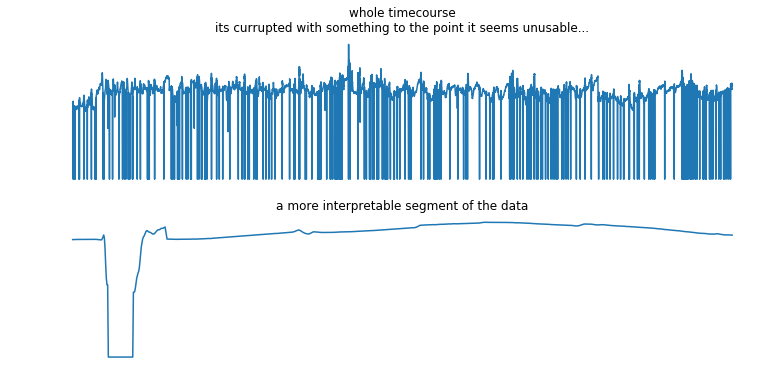

In [216]:
plt.figure(figsize=[13,6])
plt.subplot(2,1,1)
plt.plot(pupil_data)
plt.title('whole timecourse\nits currupted with something to the point it seems unusable...', fontsize=12)
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(pupil_data[5000:6000]); 
plt.title('\na more interpretable segment of the data', fontsize=12)
plt.axis('off'); 

> they're eyeblinks :) which is pretty incredible. naively we might preprocess the data like we do with skin conductance data--that is, high and low pass filter the data to remove noise, e.g. [Bach et al. 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2877881/). let's use a function from experiment 1 and look at the data again

In [217]:
import scipy.signal as signal

In [218]:
def filter_data(input_data, start_int=0, len_int=10000): 
    
    filter_order = 2 
    lowpass_cutoff = 0.0001
    highpass_cutoff = .005
    
    # First, design the Buterworth filter to extract lowest frequency variation - a better mean, basically, to subtract
    B_1, A_1= signal.butter(filter_order, lowpass_cutoff, output='ba') 
    low_freq = signal.filtfilt(B_1,A_1, input_data)

    # extract the frequency range of likely motion artifacts
    B_2, A_2 = signal.butter(filter_order, highpass_cutoff, output='ba') 
    below_high = signal.filtfilt(B_2, A_2, input_data)
    filtered_data = below_high - low_freq

    # zscore the filtered data
    filtered_data = (filtered_data-np.mean(filtered_data))/np.std(filtered_data)
    
    if start_int: 
        end_int = start_int + len_int
    else: 
        start_int = 0
        end_int = len(input_data)
        

    def slice_data(data_in,start_int, end_int): 
        return data_in[start_int:start_int+end_int]
        
        
    
    input_data = slice_data(input_data, start_int, end_int)
    low_freq = slice_data(low_freq, start_int, end_int)
    below_high = slice_data(below_high, start_int, end_int)
    filtered_data = slice_data(filtered_data, start_int, end_int)

    plt.figure(figsize=(20,5))
    plt.plot(input_data, 'xkcd:blue',alpha=.4, linewidth=2)
    plt.plot(low_freq, 'r-',alpha=.3,linewidth=5)
    plt.plot(below_high,'indigo',linewidth=3,alpha=.7)
    plt.legend(['Original','low pass filtered','high pass filtered'])
    plt.figure(figsize=(20,3))
    plt.ylim([min(filtered_data)-.25,max(filtered_data)+.25]); 
    plt.xlim([0,len(filtered_data)])  
    plt.plot(filtered_data,'indigo',linewidth=3,alpha=.7,color='xkcd:blue')
    plt.legend(['bandpass filtered data'])


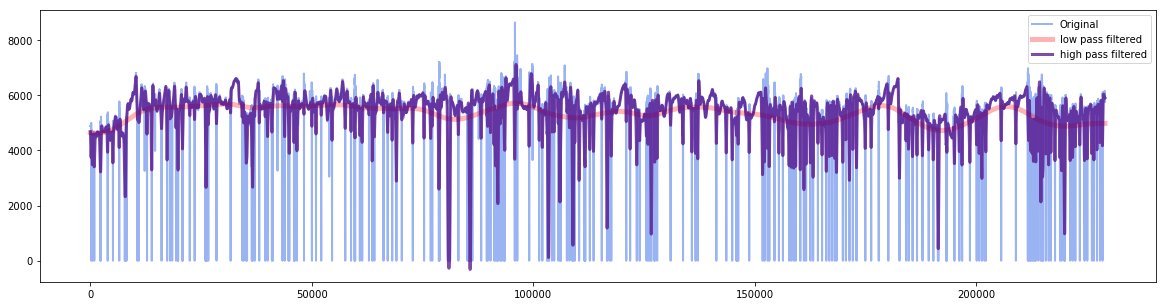

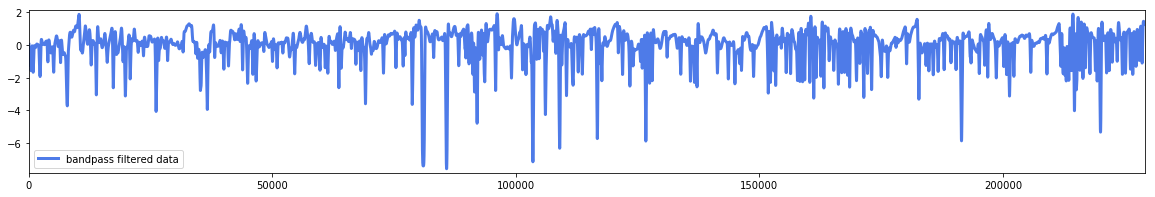

In [219]:
filter_data(pupil_data)

> this still seems awfully noisy ... let's look more closely 

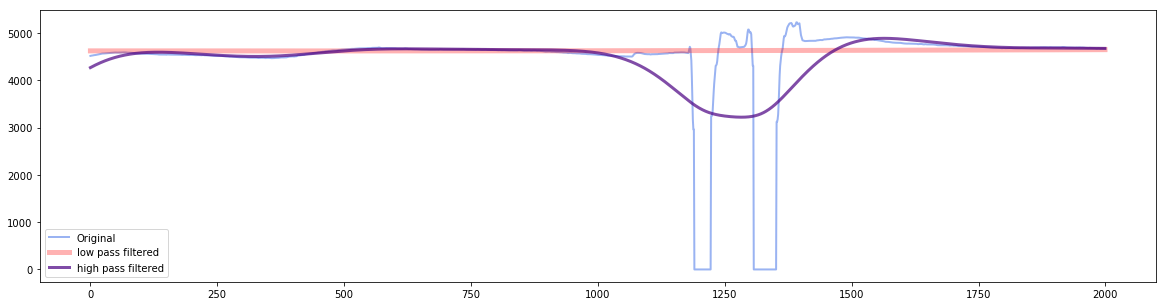

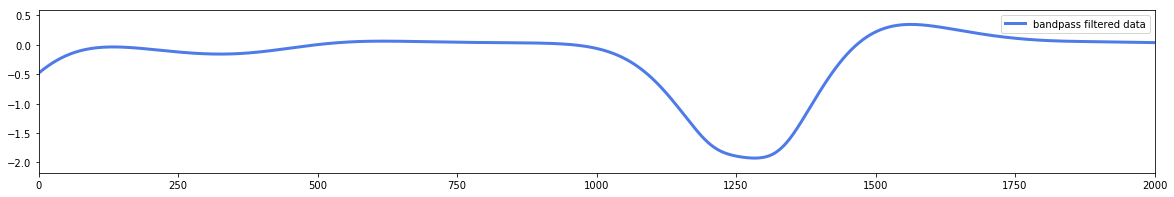

In [220]:
filter_data(pupil_data, start_int=1000, len_int=1000)

> when people blink the instrument records a zero, and these zeros introduce more variance in the timecourse than is naturally present. if we were to set the 0 = NaN we couldn't use the bandpass filter here ... other options? for the moment just skip reading through the function, pick some interval to look at, and look at the outputs

In [221]:
def dpupil_dtime(i_segment, interval=1): 

    # initiate data structures
    indices = []
    dp_dt = np.zeros(len(i_segment))
    
    # define blink as time when no measurements taken--super conservative
    blink_segment = np.repeat(np.nan, len(i_segment))
    blink_segment[i_segment==0] = 1 * np.mean(i_segment)
    
    # take interval if we're subsampling the data (to get bigger deltas)
    sliced_segment = i_segment[::interval]
    index_segment = np.array(list(range(len(i_segment)))[0::interval])
    
    # preserve the length of the segment, even if we're subsampling
    for ii in range(1, len(sliced_segment)): 
        dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

    return abs(dp_dt), blink_segment

def show_blink_generation(pupil_data, skip=5, start_ind=0, ind_length=1000, set_thresh = 200, description=0): 
    
    conv_filter_length = 20 
    
    # segment the data into an interval--for troublshooting
    segment = pupil_data[start_ind:start_ind+ind_length]
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = dpupil_dtime(segment, interval=skip)
    
    plt.figure(figsize=[20,4])
    plt.plot(segment, 'b-', alpha=.1, linewidth=5)
    plt.plot(segment, 'b-', alpha=.6, linewidth=1)
    plt.legend(['pupil diameter'])
    if description: plt.title('\n if were looking for "blinks" in our data...\n', fontsize=15)
    
    plt.figure(figsize=[20,4])
    plt.plot(delta, 'r-', alpha=.5)
    plt.plot(naive_blink, 'm-', linewidth=5, alpha=.5)
    plt.legend(['dp_dt', 'naive_blink'])
    if description: plt.title('first we calculate the change in pupil size over time (dPupil_dTime) \n' + 
              ' and the intervale of naive_blink, when peoples eyes are completely closed ...\n', fontsize=15)
    
    # convolve, etc.
    delta[naive_blink==naive_blink] = 1000
    wide_delta = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]
    blink = np.repeat(np.nan, len(segment))
    blink[wide_delta > set_thresh] = np.mean(segment) + 2000
    blink[naive_blink > 0] = np.mean(segment) + 2000
    
    
    plt.figure(figsize=[20,4])
    plt.plot(np.convolve(delta,np.ones(conv_filter_length)), 'm-', alpha=.1, linewidth=8)
    plt.plot(np.convolve(delta,np.ones(conv_filter_length)), 'm-', alpha=.6, linewidth=2)
    plt.plot(range(len(delta)), np.repeat(set_thresh, len(delta)), '--', linewidth=5, alpha=.4)
    plt.legend(['convolve(naive_blink + delta_pupil)', 'threshhold'])
    if description: plt.title('add naive_time + dpupil_dtime, convolve them' +   
              'and then set a "reasonable" (a.k.a. arbitrary) threshhold of what counts as a blink ... \n', fontsize=15)
    
    plt.figure(figsize=[20,4])
    plt.plot(blink, 'k-', alpha=.6, linewidth=4)    
    plt.plot(segment, 'b-', alpha=.1, linewidth=5)
    plt.legend(['pupil diameter', '"blink"'])
    plt.plot(segment, 'b-', alpha=.6, linewidth=1)
    if description: plt.title('and now we can figure out what to do with the "blinks" in our data\n', fontsize=15)

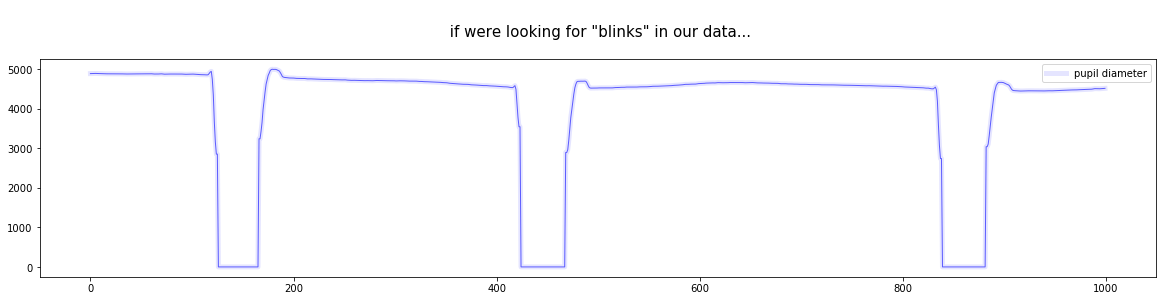

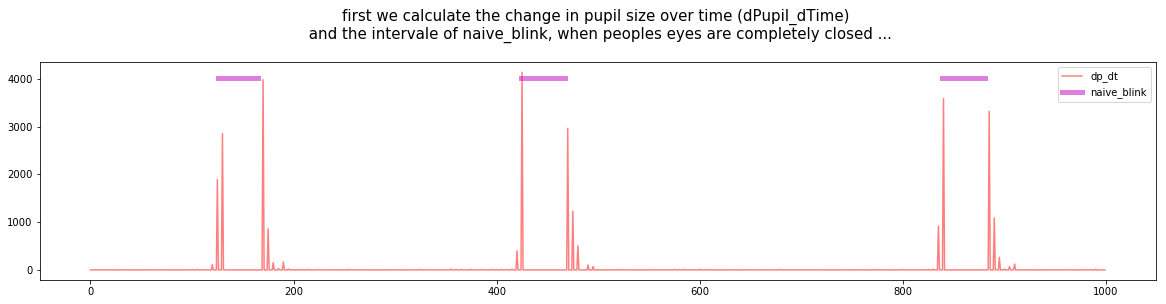

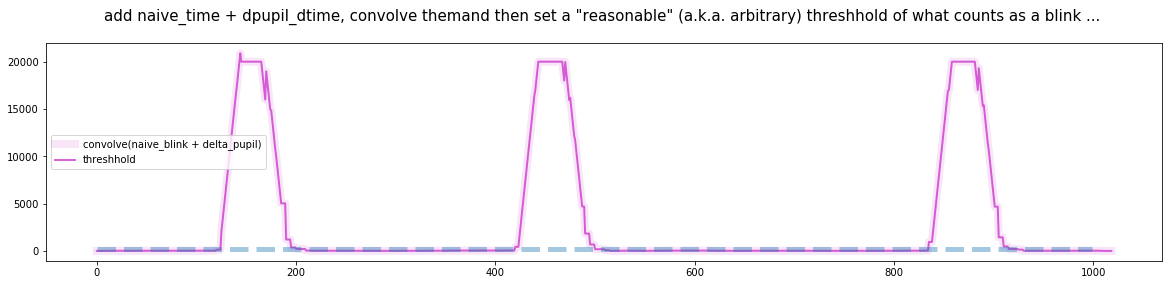

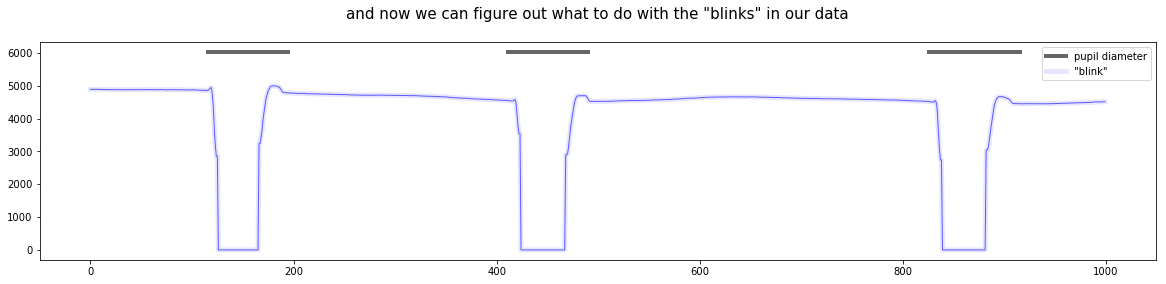

In [222]:
show_blink_generation(pupil_data, description=1)

> 
if youd like you can experiment with the data a bit by changing these parameters
> 
```
            skip, start_ind, ind_length, set_thresh
```
- skip: the sampling interval to calculate the change in pupil size
- start_ind: where to begin looking at the timecourse
- ind_length: how long of a timecourse to look at
- set_thresh: the arbitrary threshhold we use to determine what counts as a "blink" 
- these are the default parameters
```
skip=5, start_ind=0, ind_length=1000, set_thresh = 200
```

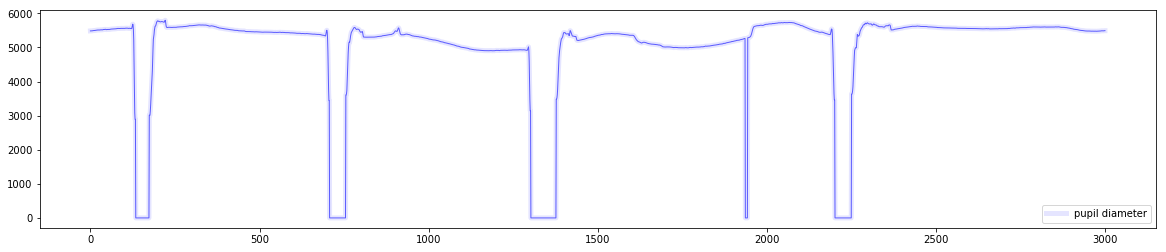

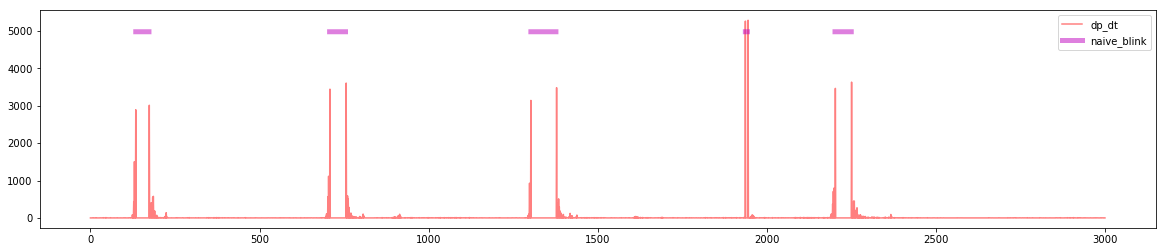

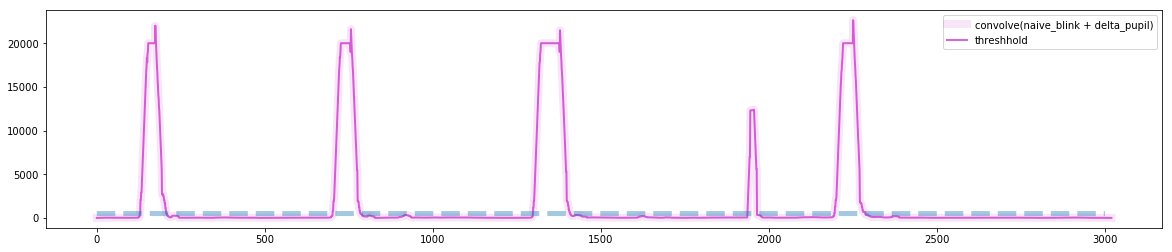

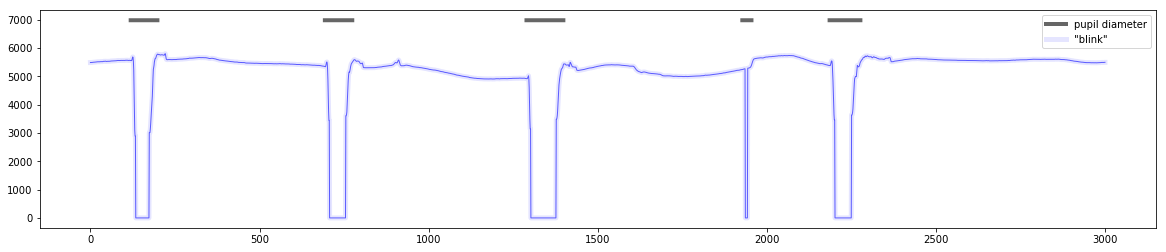

In [223]:
# set variables if you'd like
start_ind = 200000
ind_length = 3000
set_thresh = 500
skip = 2

show_blink_generation(pupil_data, skip, start_ind, ind_length, set_thresh)

> ideally, we'd be able to salvage the data, even though it's blotted out by the blinks. a "reasonable" assumption is that pupil diameter would have changed smoothly between before and after the blink occured. so we might be able to just remove the blink and make a smooth line connecting the pupil diameter from before to after it occured


> let's clean up the function above, and make sure it can return what we need so we can just use to for the next step

In [224]:
def find_blinks(pupil_data, skip=5, conv_filter_length=20, set_thresh = 200, description=0): 
    
    # segment the data into an interval--for troublshooting
    segment = pupil_data
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = dpupil_dtime(segment, interval=skip)
 
    # convolve, etc.
    delta[naive_blink==naive_blink] = 1000
    wide_delta = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]
    blink = np.repeat(np.nan, len(segment))
    blink[wide_delta > set_thresh] = np.mean(segment) + 2000
    blink[naive_blink > 0] = np.mean(segment) + 2000
    
    blink[blink == blink] = 1000
    return blink

def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])

In [225]:
blink = find_blinks(pupil_data, conv_filter_length=30, set_thresh=200)

In [226]:
ind1 = 00000 ; ind2  = ind1 + 1000

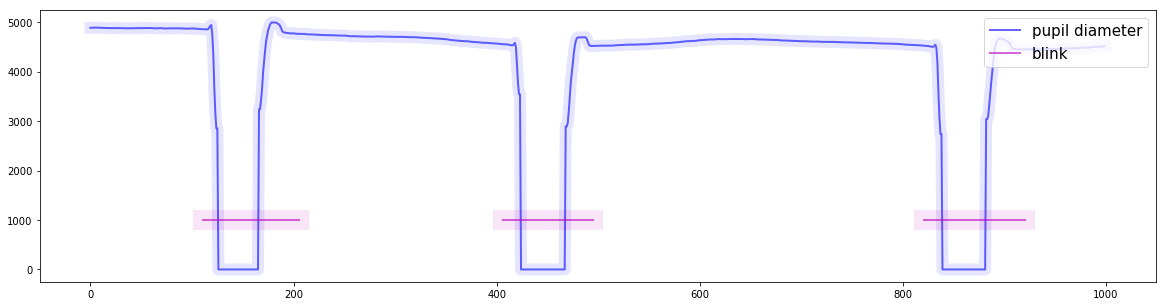

In [227]:
plt.figure(figsize=[20, 5])
nice_lines(pupil_data[ind1:ind2], 'pupil diameter', 'b')
nice_lines(blink[ind1:ind2], 'blink','m', light=[.1,20])
plt.legend(prop={'size': 15}, loc=1)

> a **`class`** that would perform all the steps we've outlined up to this point, for one subject, might look something like this: 

In [228]:
import numpy as np
import csv, os

In [229]:
import matplotlib.pylab as plt

In [230]:
% matplotlib inline 

In [231]:
def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])

In [232]:
class eyelink_data: 
    
    def __init__(self, subject_number=14): 
        """initialize path and preproocessing setting"""
        
        # relative path to data and subject_n
        self.data_path = '../../collection/gaze_data/'
        self.i_subject = subject_number
        # hyperparameters for determining blinks
        self.conv_filter_length = 20
        self.set_thresh = 500
        self.skip = 5
        
        
    def load_subject(self):
        """loads eyelink-converted asc files containing"""
        
        data_file_names = []
        folder_contents = os.listdir(self.data_path)
        
        for file in folder_contents: 
            if 'd1.asc' in file: 
                data_file_names.append(file)

        subject_path = self.data_path + data_file_names[self.i_subject]
        print('collecting gaze data from: ' + subject_path)
         
        with open(subject_path) as f:
            reader = csv.reader(f, delimiter="\t")
            # save data file to class 
            self.subject_data = list(reader)

    def extract_pupil_data(self): 
        """extracts pupil size from eyelink-converted converted asc files"""

        # initialize data structures and load data
        pupil_data = []
        pupil_column = 3 
        self.load_subject() 
        
        # extract pupil diameter from data file 
        for i_row in range(len(self.subject_data)): 
            try: 
                int(self.subject_data[i_row][0])
                i_pupil = self.subject_data[i_row][pupil_column]
                pupil_data.append(float(i_pupil))
            except: 
                pass 
            
        # save pupil data to class instance
        self.pupil_data = np.array(pupil_data)
    
    def dpupil_dtime(self): 
        """determined the change in pupil size across an interval set by 'skip'"""
        
        # initiate data structures
        indices = []
        dp_dt = np.zeros(len(self.pupil_data))

        # define blink as time when no measurements taken--super conservative
        blink_segment = np.repeat(np.nan, len(self.pupil_data))
        blink_segment[self.pupil_data==0] = 1 * np.mean(self.pupil_data)

        # take interval if we're subsampling the data (to get bigger deltas)
        sliced_segment = self.pupil_data[::self.skip]
        index_segment = np.array(list(range(len(self.pupil_data)))[0::self.skip])

        # preserve the length of the segment, even if we're subsampling
        for ii in range(1, len(sliced_segment)): 
            dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

        return abs(dp_dt), blink_segment

    
    def find_blinks(self): 
        """determine when blinks occur in timecourse"""
        
        # extract change in pupil size and a naive blink measure
        delta, naive_blink = self.dpupil_dtime()

        # convolve, etc.
        delta[naive_blink==naive_blink] = 1
        wide_delta = np.convolve(delta,np.ones(self.conv_filter_length), 'same')[0:len(delta)]
        blink = np.repeat(np.nan, len(self.pupil_data))
        blink[wide_delta > self.set_thresh] = 1
        blink[naive_blink > 0] = 1
        
        blink[blink == blink] = 1
        return blink, self.pupil_data


> below are some useful ways to cue the class

In [233]:
example = eyelink_data()
example.extract_pupil_data()

collecting gaze data from: ../../collection/gaze_data/s12_d1.asc


In [234]:
blinks, pupil = example.find_blinks() # we can also get `pupil = example.pupil_data`

> and just to check that it's working properly 

In [235]:
ind1 = 5000 ; ind2  = ind1 + 5000

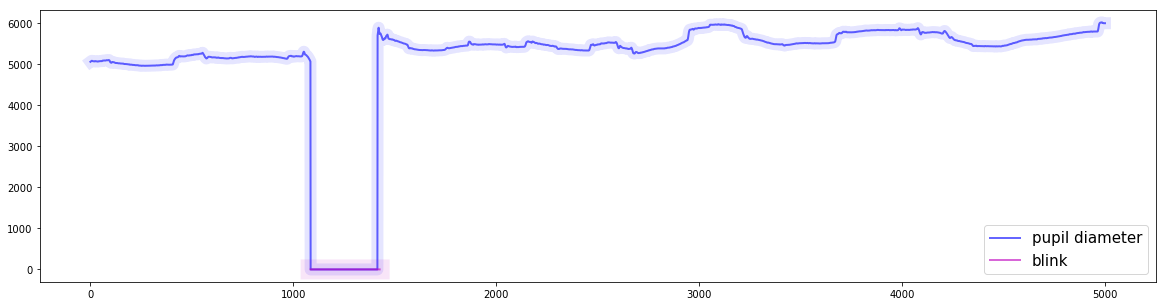

In [236]:
plt.figure(figsize=[20, 5])
nice_lines(pupil[ind1:ind2], 'pupil diameter', 'b')
nice_lines(blinks[ind1:ind2], 'blink','m', light=[.1,20])
plt.legend(prop={'size': 15}, loc=4); 

> we can load different subjects a couple of ways

In [237]:
i_subject = 5

In [238]:
example = eyelink_data(i_subject)
example.extract_pupil_data()

collecting gaze data from: ../../collection/gaze_data/s05_d1.asc


## PREPROCESSING "BLINKS" OUT OF THE TIMECOURSE

> there are a few ways to approach filling in the "blink" interval. we'll try two here, and there probably wont be a meaningful difference between the two for the eventual analysis we run, but let's give ourselves some options. a high level description of what we need to do is: find a way to replace the "blink" segments with something reasonable so  we can analyze our data and not worry that subjects' blinks are destroying the quality of the data. before reading on, maybe think about how you would approach that problem for a second. 

> generally, it's often a good idea to develop a method with **synthetic data**--that is, generating data that captures some of the core features of actual data we're interested in analyzing. sythetic data sets can be a lot faster than working with real datasets, and because you created it, it's 100% knowable, and so there's no ambiguity with something goes wrong.  

> the script above has already identified the "blink" intervals, so we need to
>    1. generate a timecourse
>    2. create multiple segments to remove within that timecourse
>    3. generate some approximation of what probably would have happened in the absence of the blink 
>    4. replace the "blink" segments with the interval we've generated. 


### GENERATE FAKE DATA 

In [239]:
import numpy as np 

In [240]:
import matplotlib.pyplot as plt

In [241]:
% matplotlib inline 

In [242]:
def generate_fake_data(): 
    
    # generate timecourse, shift accordingly
    x_range = np.arange(-50, 50)/10
    y_range = np.tanh(x_range)
    x_range = x_range + 5
    y_data = np.copy(y_range)
    # generate two "blink" segments
    fake_blink = np.zeros(len(x_range))
    fake_blink[20:30] = 1
    fake_blink[60:80] = 1 
    
    # remove data from blink segments
    y_data[fake_blink == 1] = np.nan
    
    return x_range, y_range, fake_blink, y_data
    
# def search_blinks(fake_blink_zero):
#     # convolve with an edge detector 
#     kernel = [1,-1]
#     edges = np.convolve(fake_blink_zero, kernel)
#     # find location of onsets and offsets in the timecourse
#     onsets, offsets = np.nonzero(edges == 1)[0], np.nonzero(edges == -1)[0]

#     return onsets, offsets
def search_blinks(blink_zero):
    
    if blink_zero[0] != blink_zero[0]: 
        blink_zero[blink_zero!=blink_zero] = 0 
    
    # convolve with an edge detector 
    kernel = [1,-1]
    edges = np.convolve(blink_zero, kernel)
    # find location of onsets and offsets in the timecourse
    onsets, offsets = np.nonzero(edges > 0 )[0], np.nonzero(edges < 0)[0]
    
    return onsets, offsets

In [243]:
x_range, y_range, fake_blink, y_data = generate_fake_data()

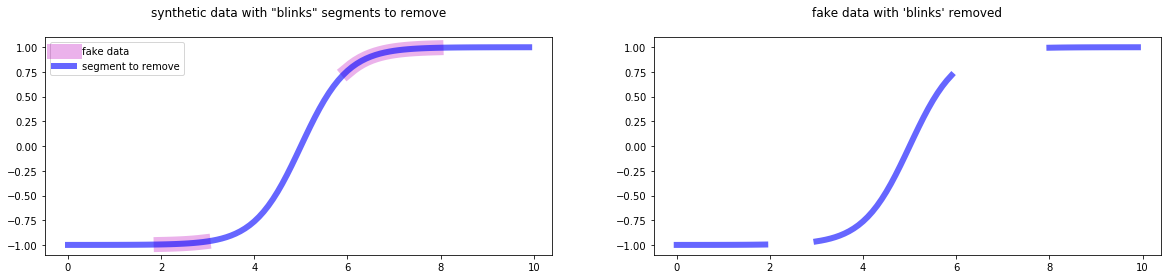

In [244]:
empty_set = np.repeat(np.nan, len(x_range))
empty_set[fake_blink==1] = y_range[fake_blink==1]

plt.figure(figsize=[20,4])
plt.subplot(121)
plt.plot(x_range, empty_set, 'm', linewidth=15,alpha=.3)
plt.plot(x_range, y_range, 'b', alpha=.6, linewidth=6)
plt.legend(['fake data', 'segment to remove'])
plt.title('synthetic data with "blinks" segments to remove\n')
plt.subplot(122) 
plt.plot(x_range, y_data, 'b', alpha=.6, linewidth=6) 
plt.title("fake data with 'blinks' removed\n"); 

### METHOD ONE:
> start simple to build up dexterity and intuition about the data types and operations

In [245]:
def simple_connect(y_range, fake_blink): 
    
    onsets, offsets = search_blinks(fake_blink)
    # generate data structure for connect info  
    fill_blink = np.repeat(np.nan, len(y_data))

    for i_blink in range(len(onsets)): 
        # extract indices around "blink" 
        onset_ind = onsets[i_blink] - 1
        offset_ind = offsets[i_blink] + 1
        # so that we can extract the values 
        onset_val = y_range[onset_ind]
        offset_val = y_range[offset_ind]
        # determine the "step" to increment values by
        step_size = abs(onset_val - offset_val)/ (offset_ind - onset_ind)
        # create a line that connects the end points
        connecting_line = np.arange(onset_val, offset_val, step_size)   
        # create daat type for format line for whole timecourse
        fill_blink[onset_ind:offset_ind] = connecting_line
    
    return fill_blink

In [246]:
# generate synthetic data
x_range, y_range, fake_blink, y_data = generate_fake_data()
# find a line between last and first points around blink
fill_blink = simple_connect(y_range, fake_blink)
# now fill in the original timecourse
y_data[fill_blink==fill_blink] = fill_blink[fill_blink==fill_blink]

#### PLOT OUR RESULTS

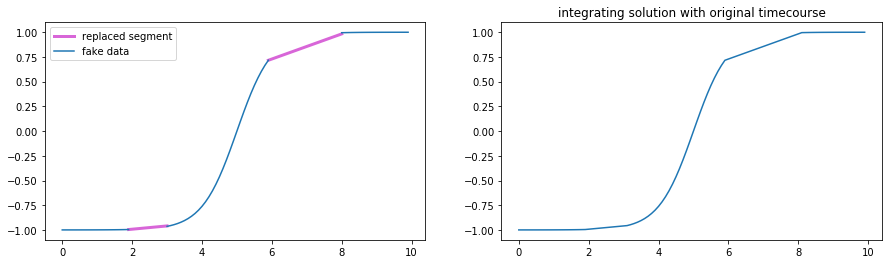

In [247]:
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(x_range, fill_blink, color='m', alpha=.6, linewidth=3)
y_range[fake_blink==1] = np.nan
plt.plot(x_range, y_range)
plt.legend(['replaced segment', 'fake data'])
plt.subplot(122) 
plt.plot(x_range, y_data); 
plt.title('integrating solution with original timecourse'); 

In [248]:
def fill_blinks(y_data, fill_data): 
    """fills blink spaces in 'y_data' with generated  """
    if len(y_data) == len(fill_data): 
        y_data[fill_data==fill_data] = fill_data[fill_data==fill_data]
        return y_data
    else: print ('ERROR: y_data AND fill_data MUST BE THE SAME LENGTH')

### METHOD TWO

In [249]:
def polynomial_fill_blinks(y_data, blink, window_size=5, show=0, order=2): 
    """
    y_data = vector  
    blink
    window_size=5
    show=0
    """
    # generate indices for pupil measurements
    x_range = np.arange(len(y_data))
    
    # identify "blink" onsets and offsets
    onsets, offsets = search_blinks(blink)

    # generate data structure for blink fills 
    poly_fill_blinks = np.repeat(np.nan, len(x_range))
    poly_edge_blinks = np.repeat(np.nan, len(x_range))
    
    # edge around blink to include in polynomial fit 
    window_size = window_size 
    
    if show: plt.figure(figsize=[15,4]) 
        
    for i_blink in range(len(offsets)): 

        # define n_inds to include around "blink"
        poly_fit_ons = onsets[i_blink] - window_size
        poly_fit_off = offsets[i_blink] + window_size

        # extract interval polynomial will be fit to
        x_short = x_range[poly_fit_ons:poly_fit_off]
        y_short = y_data[poly_fit_ons:poly_fit_off]

        # find polynomial fit to window around "blink" 
        edge_function = np.polyfit(x_short[y_short==y_short], y_short[y_short==y_short], order)
        function_ = np.poly1d(edge_function)
        i_fill_blink = function_(x_short)[window_size:-window_size]

        poly_fill_blinks[onsets[i_blink]:offsets[i_blink]] = i_fill_blink
        poly_edge_blinks[poly_fit_ons:poly_fit_off] = y_data[poly_fit_ons:poly_fit_off]

        if show: 

            empty_set_ref = np.repeat(np.nan, len(x_range))
            empty_set_ref[poly_fit_ons:poly_fit_off] = y_data[poly_fit_ons:poly_fit_off]
            empty_set_poly = np.repeat(np.nan, len(x_range))
            empty_set_poly[onsets[i_blink]:offsets[i_blink]] = i_fill_blink

            plt.subplot(1,2,i_blink+1)
            plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
            plt.scatter(x_range[empty_set_ref==empty_set_ref],empty_set_ref[empty_set_ref==empty_set_ref], marker='o', s=20)

            plt.plot(x_range, empty_set_poly, 'm', alpha=.5, linewidth=5)

            plt.legend(['   "pupil" data', '  polynomial fit', 'edges used to \n fit polonomial'], prop={'size': 10})
            plt.title("polynomial fit to 'blink' %s\n"%i_blink);
            plt.axis('off')

    return poly_fill_blinks, poly_edge_blinks

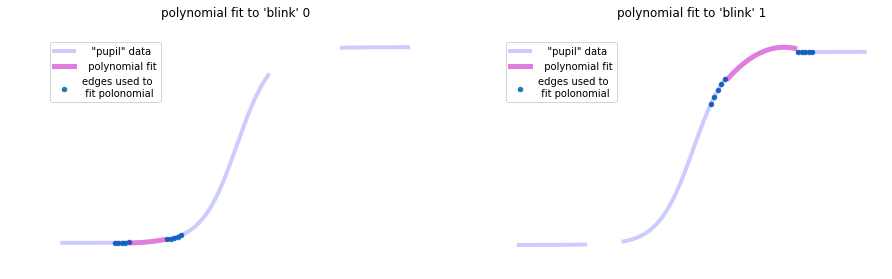

In [250]:
# generate fake data
x_range, y_range, fake_blink, y_data = generate_fake_data()
# find polynomial fit to edges around "blinks" 
poly_blinks, poly_edges = polynomial_fill_blinks(y_data, fake_blink, show=1)

> let's look at our two methods side by side, generating our new data from scratch

In [251]:
# generate and preprocess synthetic data for method one
x_range, y_range, blinks, y_data_m1 = generate_fake_data()
# fine line fits to fill gaps left by removing blinks
line_fill = simple_connect(y_range, blinks)
# fill original data structure with line_fill
line_data = fill_blinks(y_data_m1, line_fill)

# generate and preprocess synthetic data for method two
x_range, y_range, blinks, y_data_m2 = generate_fake_data()
# find polynomial fit to edges around "blinks" 
poly_fill, poly_edges = polynomial_fill_blinks(y_data_m2, fake_blink)
# fill original data structure with poly_fill
poly_data = fill_blinks(y_data_m2, poly_fill)

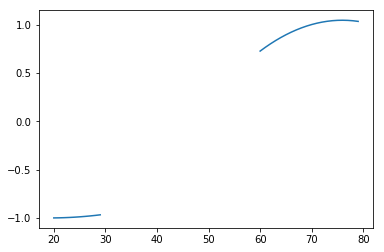

In [252]:
plt.plot(poly_fill)

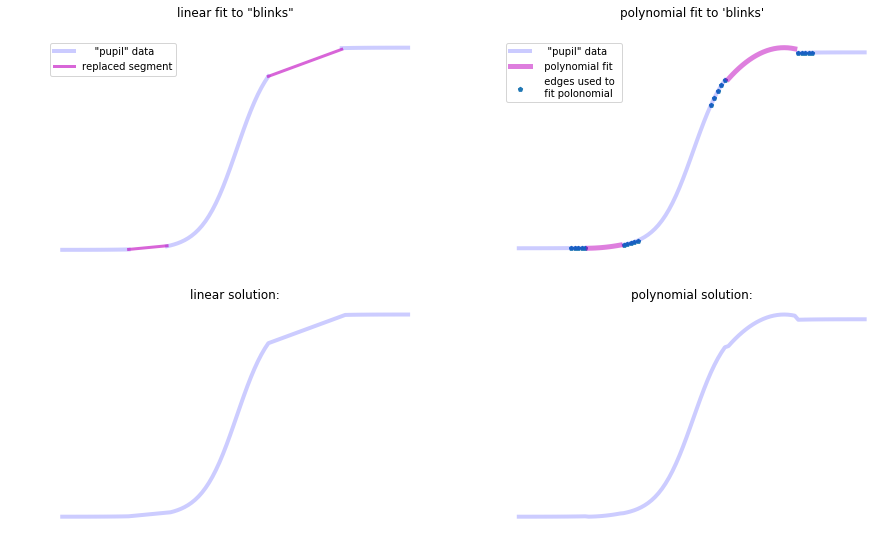

In [253]:
plt.figure(figsize=[15,9])
plt.subplot(221)
plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
plt.plot(x_range, fill_blink, color='m', alpha=.6, linewidth=3)
plt.legend(['    "pupil" data', 'replaced segment'])
plt.title('linear fit to "blinks"\n')
plt.axis('off')
plt.subplot(2,2,2)
plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
plt.scatter(x_range[poly_edges==poly_edges],poly_edges[poly_edges==poly_edges], marker=(5, 0), s=20)
plt.plot(x_range, poly_blinks, 'm', alpha=.5, linewidth=5)
plt.legend(['   "pupil" data', '  polynomial fit', '  edges used to \n  fit polonomial'], prop={'size': 10}, loc=2)
plt.title("polynomial fit to 'blinks'\n");
plt.axis('off')
plt.subplot(223) 
plt.plot(x_range, line_data, 'b', alpha=.2, linewidth=4); 
plt.title('\nlinear solution:'); 
plt.axis('off')
plt.subplot(224) 
plt.plot(x_range, poly_data,'b', alpha=.2, linewidth=4); 
plt.title('\npolynomial solution:'); 
plt.axis('off'); print('\n\n')

> now let's test this on our original data. this is messy at the moment, but it works

In [254]:
# extract data
example = eyelink_data()
example.extract_pupil_data()

# define blink times
blinks, pupil = example.find_blinks()
# select an interval 
a, b = 0, len(pupil)
pupil = pupil[a:b]
blinks = blinks[a:b]
# extract onsets and offsets
onsets, offsets = search_blinks(blinks)
# polynomial order 
order = 1
# set blinks to NaNs
pupil[blinks==1] = np.nan

# interpolate betwen blinks
poly_fill, poly_edges = polynomial_fill_blinks(pupil, blinks, window_size=20, order=order)

# use old naming for convenience
x_range = np.arange(0, len(pupil))
y_data = pupil

# fill gaps 
pupil[poly_fill == poly_fill] = poly_fill[poly_fill == poly_fill]

collecting gaze data from: ../../collection/gaze_data/s12_d1.asc


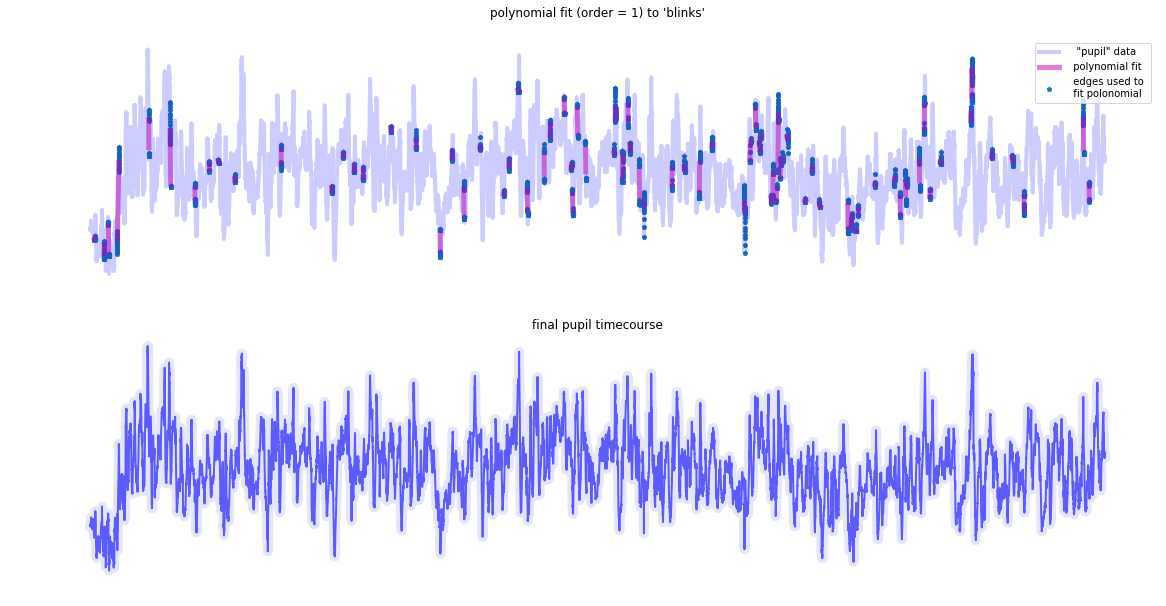

In [255]:
# visualize steps
plt.figure(figsize=[20,10])
plt.subplot(2,1,1); plt.axis('off'); 
plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
plt.scatter(x_range[poly_edges==poly_edges],poly_edges[poly_edges==poly_edges], marker=(5, 0), s=20)
plt.plot(x_range, poly_fill, 'm', alpha=.5, linewidth=5)
plt.legend(['   "pupil" data', '  polynomial fit', '  edges used to \n  fit polonomial'], prop={'size': 10}, loc=1)
plt.title("polynomial fit (order = %s) to 'blinks'\n"%order);
# visualize completed 
plt.subplot(2,1,2) ; plt.axis('off'); 
plt.plot(pupil, 'b', linewidth=2, alpha=.6)
plt.plot(pupil, 'b', linewidth=10, alpha=.1)
plt.title('final pupil timecourse')

In [256]:
import scipy.signal as signal

In [257]:
def filter_data(input_data, start_int=0, len_int=10000, filter_order=2, lowpass_cutoff=0.00001, highpass_cutoff=.01, show=0): 
    
    # First, design the Buterworth filter to extract lowest frequency variation - a better mean, basically, to subtract
    B_1, A_1= signal.butter(filter_order, lowpass_cutoff, output='ba') 
    low_freq = signal.filtfilt(B_1,A_1, input_data)

    # extract the frequency range of likely motion artifacts
    B_2, A_2 = signal.butter(filter_order, highpass_cutoff, output='ba') 
    below_high = signal.filtfilt(B_2, A_2, input_data)
    filtered_data = below_high - low_freq

    # zscore the filtered data
    filtered_data = (filtered_data-np.mean(filtered_data))/np.std(filtered_data)
    
    if start_int: 
        end_int = start_int + len_int
    else: 
        start_int = 0
        end_int = len(input_data)
        

    def slice_data(data_in,start_int, end_int): 
        return data_in[start_int:start_int+end_int]
        
        
    
    input_data = slice_data(input_data, start_int, end_int)
    low_freq = slice_data(low_freq, start_int, end_int)
    below_high = slice_data(below_high, start_int, end_int)
    filtered_data = slice_data(filtered_data, start_int, end_int)
    if show: 
        plt.figure(figsize=(20,5))
        plt.plot(input_data, 'xkcd:blue',alpha=.4, linewidth=3)
        plt.plot(low_freq, 'r-',alpha=.3,linewidth=5)
        plt.plot(below_high,'indigo',linewidth=1,alpha=.7)
        plt.legend(['Original','low pass filtered','high pass filtered'])
        plt.figure(figsize=(20,5))
        plt.ylim([min(filtered_data)-.25,max(filtered_data)+.25]); 
        plt.xlim([0,len(filtered_data)])  
        plt.plot(filtered_data,'indigo',linewidth=3,alpha=.7,color='xkcd:blue')
        plt.title('bandpass filtered data')
    
    return filtered_data


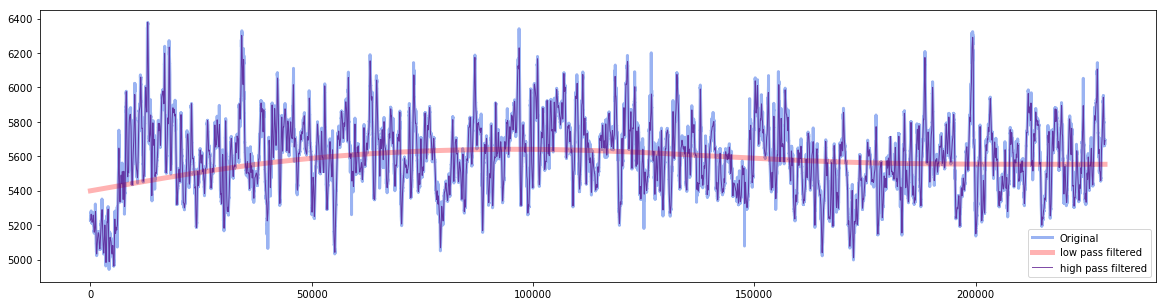

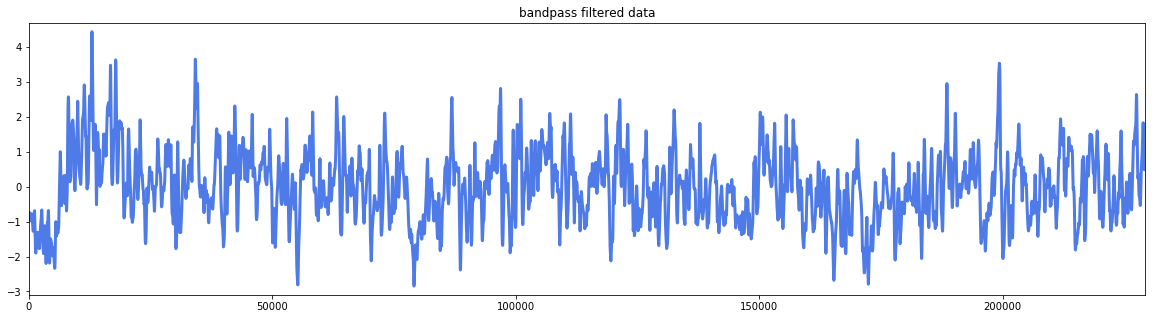

In [258]:
filter_data(pupil, show=1); 

In [259]:
def check_freq(cutoff, start_ind=5000, end_ind=8000): 
    
    pupil_clean = filter_data(pupil, highpass_cutoff=cutoff)

    plt.figure(figsize=[15,3]); plt.axis('off'); 
    plt.plot(pupil_clean[start_ind:end_ind], 'b', linewidth=2, alpha=.6)
    plt.plot(pupil_clean[start_ind:end_ind], 'b', linewidth=11, alpha=.1)
    if cutoff == .5: plt.title("let's get a closer look at the high pass filter")
    plt.legend(['cutoff = %s'%cutoff], loc=2)


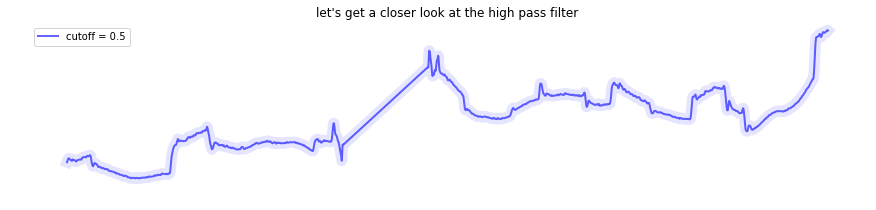

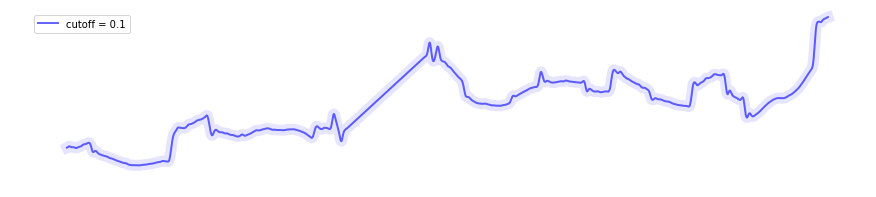

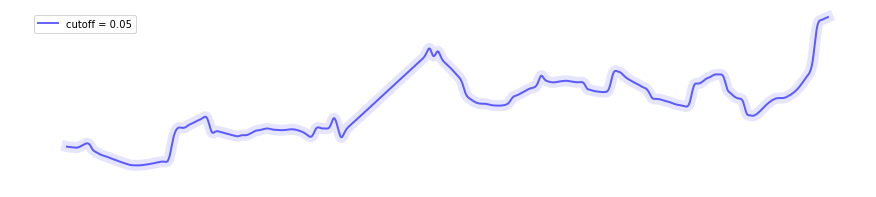

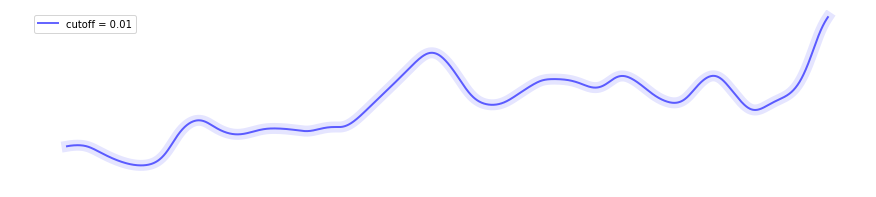

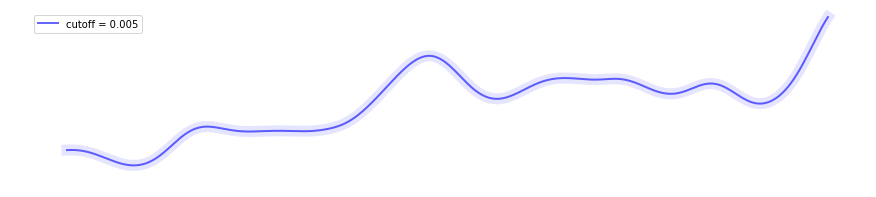

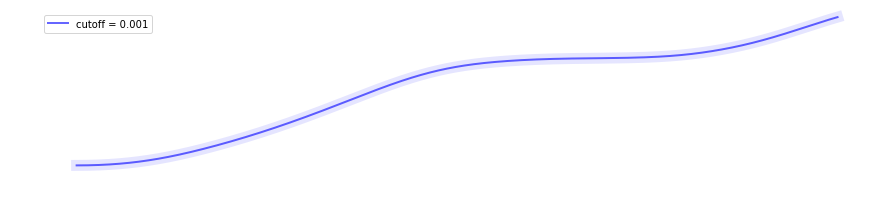

In [260]:
[check_freq(cutoff) for cutoff in [.5, .1, .05, .01, .005, .001]]; 

## TO DO: 
> - read more about butterworth filters
> - create one clean function that can iterate other subjects
> - extract stimuli information
> - figure out if there's anything you want to change about data collection
    - adding a "BEGIN TRIAL!" MSG when with biopac.begin()